# Facial Emotion Detection using Convolutional Neural Networks

## Introduction 

The objective of this project is to develop a CNN model that will, with acceptable precision, correctly label the facial expressions of different pictures of people. To execute this, we will need to acquire a large amount of data for training and testing, then assemble and train a model with said data.


## Importing Libraries 

We will use TensorFlow to handle most of our CNN operations. TensorFlow has the Keras library included, which contains useful tools such as image pre-processors and CNN layers for model construction.

## Setting Fixed Variables

For batch_size, this is to stand as the number of images to be fed into the model at a time, as well as the number of images we load into our dataset at a time. In pre-processing and model training, we will see its use. Batch size can be anything, but we are dealing with a large amount of images, so for now we'll set it to 64.

The img_size for each training/testing entry is 48x48. This is the format of the dataset I've chosen.

The test and train data directories point to two folders, where we have test images and training images respectively.

In [19]:
import tensorflow as tf
import cv2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os

batch_size = 64
img_size = 48

train_data_dir = "dataset/train/"
test_data_dir = "dataset/test/"

## Data Collection and Preprocessing

The dataset I am using to train/test our model is the FER2013 dataset from Kaggle. There are rougly 40,000 48x48 images of 7 categories of facial expression: Angry, Disgust, Fear, Happy, Neutral, Sad, and Surprise.

I've set up an ImageDataGenerator object with several pre-processing operations done that are typical for regularization. Since we specifically care that the training data is properly preprocessed, I've given most operations to the training ImageDataGenerator, and stuck with simple normalization for the test ImageDataGenerator. We simply take down the grayscale range from 0-255 to 0-1.

After the preprocessing tools are set up, next is to load the dataset from the directories we specified earlier.

In [9]:
# Preprocess settings for training set
train_preprocess = ImageDataGenerator(
                rescale=1./255,
                rotation_range=30,
                shear_range=0.3, 
                zoom_range=0.3,
                horizontal_flip=True,
                fill_mode='nearest')

# Not necessary to heavily reprocess validation set, so we just normalize
test_preprocess = ImageDataGenerator(rescale=1./255)

# Collecting all the images and categories in batches
train_ds = train_preprocess.flow_from_directory(
                train_data_dir,
                color_mode='grayscale',
                target_size=(img_size,img_size),
                batch_size=batch_size,
                class_mode='categorical',
                shuffle=True)

test_ds = test_preprocess.flow_from_directory(
                test_data_dir,
                color_mode='grayscale',
                target_size=(img_size,img_size),
                batch_size=batch_size,
                class_mode='categorical',
                shuffle=True)

class_names = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']
num_classes = len(class_names)

image, label = train_ds.__next__()

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Analyze Dataset

It's good to know what exactly we are feeding our model, so we know where its strengths and weaknesses are. 

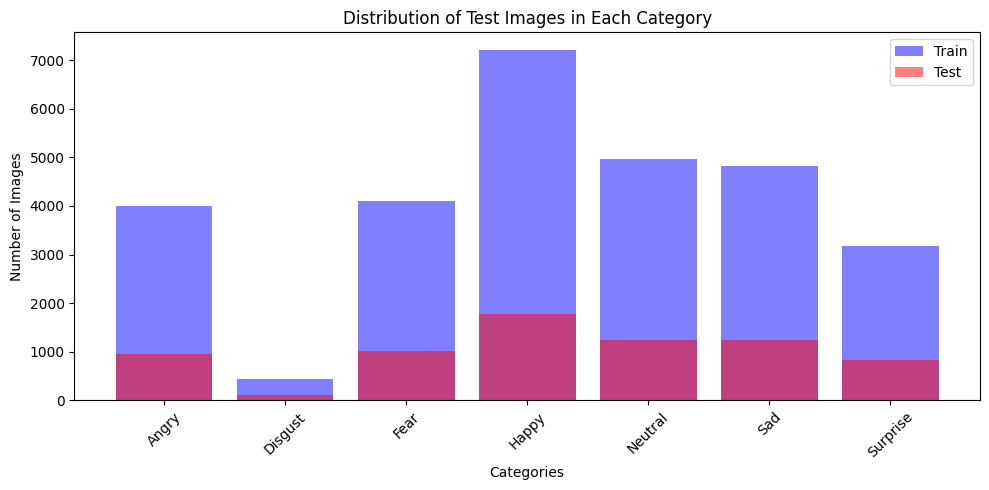

In [10]:
train_counts = {class_name: 0 for class_name in class_names}
test_counts = {class_name: 0 for class_name in class_names}

# Count the number of images for each category in the training set
for class_name in class_names:
    class_dir = os.path.join(train_data_dir, class_name.lower())
    train_counts[class_name] = len(os.listdir(class_dir))
    
# Count the number of images for each category in the test set
for class_name in class_names:
    class_dir = os.path.join(test_data_dir, class_name)
    test_counts[class_name] = len(os.listdir(class_dir))
    
plt.figure(figsize=(10, 5))
plt.bar(train_counts.keys(), train_counts.values(), color='blue', alpha=0.5, label='Train')
plt.bar(test_counts.keys(), test_counts.values(), color='red', alpha=0.5, label='Test')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Distribution of Test Images in Each Category')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We can now easily see the distribution of images in each of the categories. Most notably, in both the training and testing data, the amount of Disgust images is significantly lower than all the other categories, and the amount of Happy images is significantly larger.

Because of these large differences, we may see some damage done to our model's accuracy. Since the Happy category trumps all the others in terms of image number, there could be a bias towards labeling an image as Happy due to overfitting. Since the number of Disgust images is so low compared to all the other categories, we may see the opposite effect, where the model has not seen enough Disgust features and incorrectly labels an image due to its lack of data. 

From these differences in distribution, I predict that our model will not be as precise in its predictions, but since we are dealing with thousands of images, its accuracy should be fairly decent.

## Build the Model

Next is to create the models using Keras Layers. Below is the layout of the model I've created. Our model consists of 4 layer stacks. For better accuracy, you could add more Conv2D and MaxPool stacks, or even FC layers.

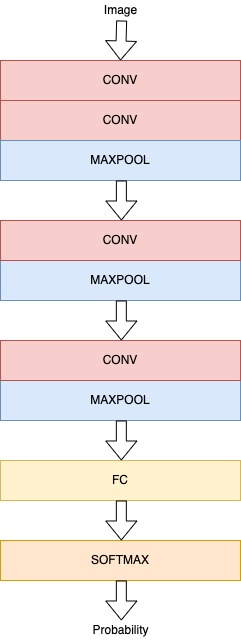

After the last Conv2D layer, we flatten the feature map into a 1D vector and feed it into a softmax Dense layer to get our final probability prediction.

For the compilation, I'm using the adam optimizer (adaptive moment estimation). The loss function is categorical crossentropy since we're dealing with various categories in this case.

In [11]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), # Reduce spatial dimension of Conv layer
    tf.keras.layers.Dropout(0.1), # Dropout to help with overfitting
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(), # Flatten 2D features into a 1D vector
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# We get a rundown on the model we created
model.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 22, 22, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                  

## Train the Model

I've chosen 30 epochs for our training. I've also included a callback for an early stop if our validation accuracy fails to improve. The patience is set to 5 since we are only using 30 epochs.

In [12]:
epochs = 30

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

history = model.fit(train_ds, 
          epochs=epochs,
          validation_data=test_ds,
          callbacks=[early_stopping])

model.save('model_30_epochs.h5')

Epoch 1/30
449/449 [==============================] - 128s 284ms/step - loss: 1.7738 - accuracy: 0.2669 - val_loss: 1.6791 - val_accuracy: 0.3137
Epoch 2/30
449/449 [==============================] - 118s 263ms/step - loss: 1.6636 - accuracy: 0.3370 - val_loss: 1.4849 - val_accuracy: 0.4274
Epoch 3/30
449/449 [==============================] - 125s 279ms/step - loss: 1.5084 - accuracy: 0.4164 - val_loss: 1.3364 - val_accuracy: 0.4916
Epoch 4/30
449/449 [==============================] - 121s 270ms/step - loss: 1.4007 - accuracy: 0.4619 - val_loss: 1.2515 - val_accuracy: 0.5249
Epoch 5/30
449/449 [==============================] - 119s 265ms/step - loss: 1.3390 - accuracy: 0.4848 - val_loss: 1.2017 - val_accuracy: 0.5382
Epoch 6/30
449/449 [==============================] - 119s 265ms/step - loss: 1.2868 - accuracy: 0.5112 - val_loss: 1.2017 - val_accuracy: 0.5355
Epoch 7/30
449/449 [==============================] - 119s 266ms/step - loss: 1.2638 - accuracy: 0.5160 - val_loss: 1.1465 -

We now have our trained model for the seven facial expressions loaded into a history variable and saved into a .h5 file. In our run, no early stopping was needed.

#### Our model ended with a training accuracy of 60.47% and a loss of 1.0447, and a validation accuracy of 62.15% and a loss of 1.0121

## Inspect Model Accuracy

With our newly trained model, we can visualize the accuracy improvements occuring in each epoch.

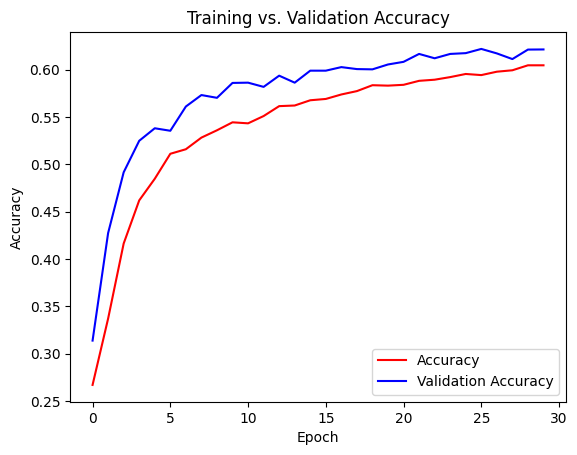

In [14]:
# Show accuracy diagram
plt.title('Training vs. Validation Accuracy')
plt.plot(history.history['accuracy'], label='accuracy', color='red')
plt.plot(history.history['val_accuracy'], label='val_accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.show()

Here we can observe how the validation accuracy compared to the training accuracy at a given epoch. As we can see, the validation accuracy stayed slightly better than the training accuracy. With more epochs, we may see the reverse effect, as our model would begin to memorize the image data it keeps receiving and overfit for the training set. 

## Evaluate Model

Now that our model has been trained, we can inspect it to see where it is strong or weak. A convenient way to view this is a confusion matrix, which represents the prediction summary in a matrix format.

113/113 [==============================] - 7s 61ms/step


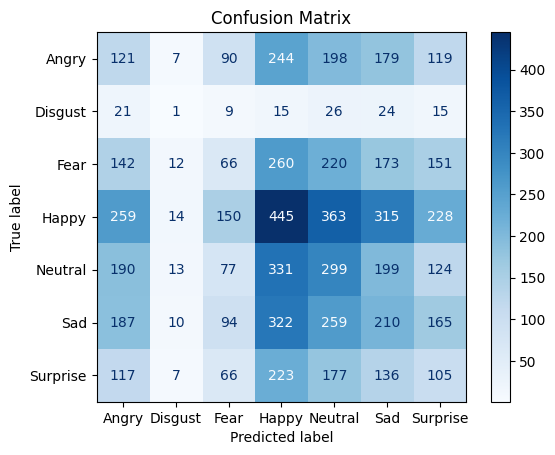

In [16]:
# Make predictions on the test dataset
predictions = model.predict(test_ds)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the test dataset
true_labels = test_ds.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

This matrix helps us see where our model is failing or succeeding. For example, 259 images with the true label of Happy were mislabeled as Angry. 

In our Disgust test set, only 1 of the Disgust images was correctly labeled as Disgust. Earlier, we did note that the Digust training and test sets were significantly smaller than all the other samples, so from this confusion matrix we can see the extent of the model's lack of training in that category.

Happy images were the largest category group, and our model appears to have a decent grasp on what a Happy image looks like, with the correct prediction having the highest hit rate of 445 images.

It seems that because the Happy category was the largest, a fair bit of overfitting is occuring for the other minor categories. We can see that for all the minor categories except for disgust, the majority of test images were predicted to be Happy.

## Testing the Model 

With some images found online, we can put our model's classification to the test. Below is some code to preprocess faces found in an image and label it a predicted category.

In [21]:
def preprocess_face(face_image):
    # Resize the face image to match the dimensions used during training (48x48)
    resized_face = cv2.resize(face_image, (48, 48))
    
    # Convert the resized face image to grayscale
    grayscale_face = cv2.cvtColor(resized_face, cv2.COLOR_BGR2GRAY)
    
    # Normalize pixel values to be in the range [0, 1]
    normalized_face = grayscale_face / 255.0
    
    # Expand dimensions to match the input shape expected by the model
    preprocessed_face = np.expand_dims(normalized_face, axis=-1)
    
    return preprocessed_face

1/1 [==============================] - 0s 20ms/step


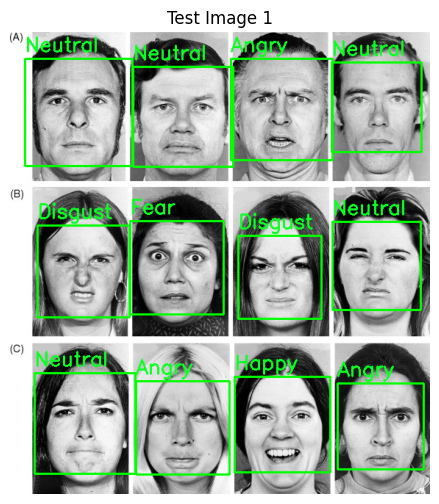

1/1 [==============================] - 0s 18ms/step


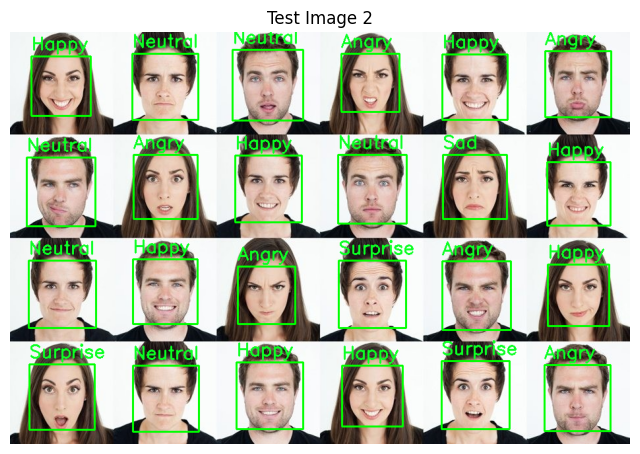

1/1 [==============================] - 0s 19ms/step


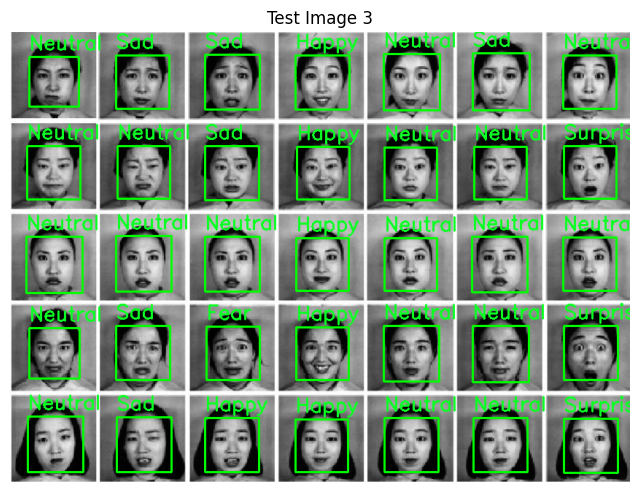

In [25]:
# Load face detection model (e.g., Haar Cascades)
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Process each test image
for i in range(1, 4):
    # Read input image
    image = cv2.imread(f'test_image_{i}.jpeg')

    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces in the grayscale image
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Iterate over detected faces
    for (x, y, w, h) in faces:
        # Extract face region from the original image
        face = image[y:y+h, x:x+w]

        # Preprocess the face image (resize, rescale, convert to grayscale, etc.)
        processed_face = preprocess_face(face)

        # Make prediction using the model
        prediction = model.predict(np.expand_dims(processed_face, axis=0))

        # Get the predicted emotion label (e.g., class with highest probability)
        predicted_emotion = class_names[np.argmax(prediction)]

        # Draw bounding box around the face
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # Put predicted emotion label on the image
        cv2.putText(image, predicted_emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

    # Display the result
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Test Image {i}')
    plt.show()

### Image 1

Test image 1 has very solid predictions. These images have no set classification category-wise, but in my opinion, the only mislabelled images would be at (A,3), (B,4), and possibly (C,1). These images could potentially be Surprise, Disgust, and Anger respectively. 
### Image 2

There are more images here, and also more subjective mislabelling. Standout errors are at (A,2), (A,3), (A,4), (A,6), (B,2), (C,6), and (D,2). I would label these as Sad, Surprise, Disgust, Sad, Surprise, Neutral, and Angry respectively. 

### Image 3

From my view, the incorrect predictions occur at (B,2), (B,6), (C,6), (C,7), (D,1), and (E,3). These could all be identified as a different category.

The subjective nature of facial expression meaning definitely plays a role in the results here. Sometimes, the differences between Sad and Disgust, or Surprise and Disgust, or Happy and Surprise may be very minimal, and it is up to the viewer of the image to make the distinction.



## Conclusion

Training a robust model for facial emotion recognition requires careful consideration of factors, like dataset quality, model architecture, training techniques, and hyperparameter optimization. By employing strategies such as data augmentation and regularization, we can enhance the model's performance and generalize better to unseen data.

To improve on our model's accuracy, we could use a more complete dataset with a better distribution of images, or specifically train our model to recognize the true category of 'hard' images.

However, for a very simple model layout and a dataset of roughly 40,000 images, a 62% validation accuracy is fairly good. With the FER2013 dataset, the best models can reach upwards of 70% accuracy. Perhaps by training our model on 'hard' data, we could get closer to that 70%.